# Testbench

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
from tqdm import tqdm

from sklearn.covariance import EmpiricalCovariance, LedoitWolf
from warnings import warn

import covariance_DRO

sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

# Coins Selected
We chose the top coins according to market cap on coinmarketcap.com as of January 19th. Excluded are coins with a short history (Polkadot, BSV) and whose price is coupled to another asset (Tether, USD Coin (USD), Wrapped Bitcoin (BTC)). Of the remaining coins, we select the 10 biggest ones according to market cap. Returns are calculated on daily close.

In [2]:
download=False
coins = ['BTC', 'ETH', 'XRP', 'ADA', 'LTC', 'BCH', 'LINK', 'XLM', 'BNB', 'XMR']
if download:
    df = None
    for coin_ticker in coins:
        coin = yfinance.Ticker(coin_ticker+'-USD')
        print(coin.info['description']+'\n')
        h = coin.history(period="max")
        h[coin_ticker] = np.log(h.Close)-np.log(h.Close.shift(1))
        if df is not None:
            df = df.join(h[[coin_ticker]])
        else:
            df=h[[coin_ticker]]
    df.to_csv('data/coins.csv')
else:
    df = pd.read_csv('data/coins.csv').set_index('Date', drop=True)

In [3]:
universe = df.dropna()

In [4]:
universe.head()

,BTC,ETH,XRP,ADA,LTC,BCH,LINK,XLM,BNB,XMR
Date,,,,,,,,,,
2017-10-02,0.001266,-0.016212,-0.018847,0.037843,-0.021634,0.014430,-0.202042,-0.054497,0.252327,-0.018162
2017-10-03,-0.021049,-0.016992,0.003163,-0.219756,-0.019417,-0.041222,-0.031989,-0.044003,-0.076103,0.015360
2017-10-04,-0.020621,0.000666,0.054815,0.052179,-0.018316,-0.120072,0.139751,-0.045607,-0.128293,-0.027859
2017-10-05,0.023150,0.010892,0.098541,-0.020360,0.005239,-0.007553,0.022832,0.206964,0.046966,0.015931
2017-10-06,0.009748,0.042111,-0.012640,-0.147665,0.008683,0.020213,0.157247,0.233137,-0.060527,-0.007311


In [5]:
universe = universe.reset_index()

# Defining Leave-1-Out Covariance Estimator

In [6]:
def l1o_cv(X, method, epsilon_candidates):
    best_epsilon, best_std = None, float('inf')
    for e in epsilon_candidates:
        returns = []
        for i in range(X.shape[0]):
            # train-validation split
            val = np.expand_dims(X[i], 0)
            train = X[np.arange(0, X.shape[0], 1) != i]
            # find the weight
            cov_inv = np.linalg.inv(method(train, e))
            ones = np.ones((cov_inv.shape[0],1))
            w = (cov_inv@ones)/(ones.T@cov_inv@ones)
            # calculate portfolio returns and metrics
            returns.append(val@w)
        # keep track of best epsilon
        std = np.std(returns)
        mean = np.mean(returns)
        sharpe = mean/std
        if std < best_std:
            best_std = np.std(returns)
            best_epsilon = e
    
    # warn if best epsilon is on border
    if best_epsilon==epsilon_candidates[0]:
        warn('Epsilon on left side of interval')
    if best_epsilon==epsilon_candidates[-1]:
        warn('Epsilon on right side of interval')
    # return estimated covariance matrix
    return method(X, best_epsilon)

def linearMethod(X, epsilon):
    c = EmpiricalCovariance(assume_centered=False).fit(X)
    emp_cov = c.covariance_
    mu = np.trace(emp_cov) / emp_cov.shape[0]
    cov = (1.0 - epsilon) * emp_cov
    cov.flat[:: emp_cov.shape[0] + 1] += epsilon * mu
    return cov

def linearMethodDiagonal(X, epsilon):
    c = EmpiricalCovariance(assume_centered=False).fit(X)
    emp_cov = c.covariance_
    mu = np.diag(np.diag(emp_cov))
    cov = (1.0 - epsilon) * emp_cov + mu * epsilon
    return cov

def our_methods(X, epsilon, method):
    c = EmpiricalCovariance(assume_centered=False).fit(X)
    cov = covariance_DRO.estimate_cov(c.covariance_, epsilon, method)
    return cov

# Testing Performance

In [7]:
def portfolio_tester_rolling(universe, cov_estimator, verbose=False, step=14):
    returns = None
    for i in range(0,len(universe)-2*step+1, step):
        train = universe.loc[i:i+step-1].drop('Date', axis=1).to_numpy()
        test = universe.loc[i+step:i+2*step-1].drop('Date', axis=1).to_numpy()
        # estimate covariance matrix and asset allocation
        cov_inv = np.linalg.inv(cov_estimator(train))
        ones = np.ones((cov_inv.shape[0],1))
        w = (cov_inv@ones)/(ones.T@cov_inv@ones)
        # calculate portfolio returns and metrics
        portfolio_returns = test@w
        if returns is None:
            returns = portfolio_returns.flatten()
        else:
            returns = np.hstack([returns, portfolio_returns.flatten()])
        dates = universe['Date'][step:i+2*step]
    plt.plot(returns)
    sns.despine()
    plt.show()
    std = returns.std()
    mean = returns.mean()
    sharpe = mean/std
    if verbose:
        print('Mean: {}'.format(100*mean))
        print('Std: {}'.format(100*std))
        print('Sharpe: {}'.format(100*sharpe))
    return mean, std, sharpe

Empirical Covariance:


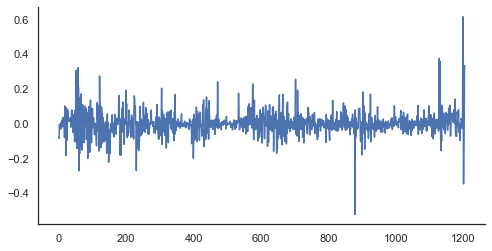

Mean: 0.1045684898397838
Std: 6.803120736336499
Sharpe: 1.537066500690891

Linear Shrikage:


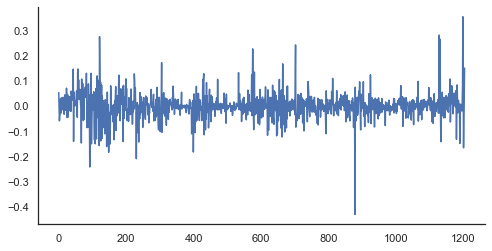

Mean: 0.06041982487960093
Std: 5.179050671486044
Sharpe: 1.166619689825596

Linear Shrikage Diagonal:


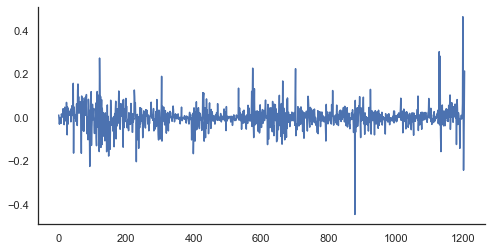

Mean: 0.08058466098216303
Std: 5.193779887682784
Sharpe: 1.5515609580081002


In [8]:
print('\033[1mEmpirical Covariance:\033[0m')
mean, std, sharpe = portfolio_tester_rolling(universe, lambda X: EmpiricalCovariance(assume_centered=False).fit(X).covariance_, verbose=True)
print('\n\033[1mLinear Shrikage:\033[0m')
mean, std, sharpe = portfolio_tester_rolling(universe, lambda X: l1o_cv(X, linearMethod, np.logspace(-5,0,50)), verbose=True)
print('\n\033[1mLinear Shrikage Diagonal:\033[0m')
mean, std, sharpe = portfolio_tester_rolling(universe, lambda X: l1o_cv(X, linearMethodDiagonal, np.logspace(-5,0,50)), verbose=True)

Wasserstein:


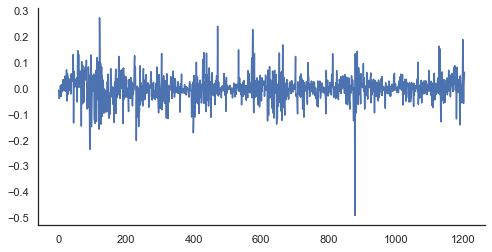

Mean: 0.058714466181162085
Std: 5.010056991982093
Sharpe: 1.1719321012740276

Kullback-Leibler:


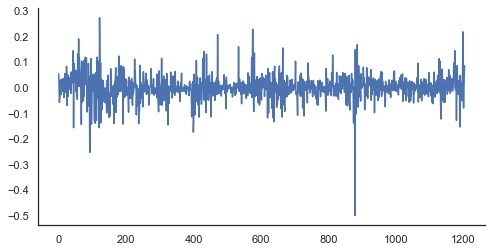

Mean: 0.0893472785519654
Std: 4.98094220057824
Sharpe: 1.793782681148017

Fisher-Rao:


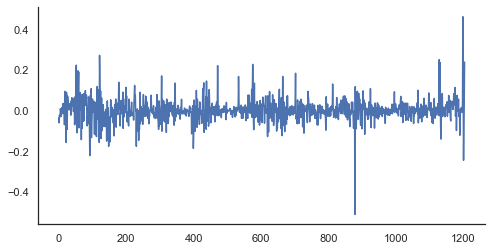

Mean: 0.09793891507675022
Std: 5.463157134884044
Sharpe: 1.7927164212681752


In [9]:
print('\033[1mWasserstein:\033[0m')
mean, std, sharpe = portfolio_tester_rolling(universe, lambda X: l1o_cv(X, lambda X, epsilon: our_methods(X, epsilon, 'Wasserstein'), np.logspace(-5,4,50)), verbose=True)
print('\n\033[1mKullback-Leibler:\033[0m')
mean, std, sharpe = portfolio_tester_rolling(universe, lambda X: l1o_cv(X, lambda X, epsilon: our_methods(X, epsilon, 'KLdirect'), np.logspace(-5,2,50)), verbose=True)
print('\n\033[1mFisher-Rao:\033[0m')
mean, std, sharpe = portfolio_tester_rolling(universe, lambda X: l1o_cv(X, lambda X, epsilon: our_methods(X, epsilon, 'Fisher-Rao'), np.logspace(-5,2,50)), verbose=True)

# Analysis

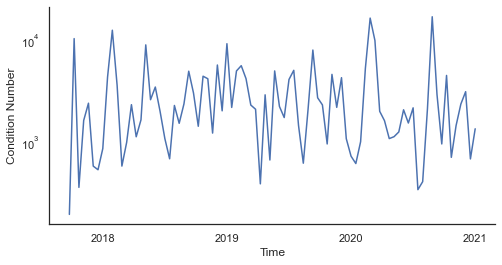

In [10]:
# plot the evolution of condition number
kappas = []
dates = []
for i in range(0,len(universe)-2*14+1, 14):
    train = universe.loc[i:i+14-1].drop('Date', axis=1).to_numpy()
    cov = EmpiricalCovariance().fit(train).covariance_
    kappas.append(np.linalg.cond(cov))
    dates.append(universe.loc[i]['Date'])
plt.plot(kappas)
sns.despine()
year_labels = ['2018', '2019', '2020', '2021']
year_index = []
for year in year_labels:
    year_index.append(next(i for i, e in enumerate(dates) if e.startswith(year)))
plt.gca().set_xticks(year_index)
plt.gca().set_xticklabels(year_labels)
plt.gca().set(yscale="log")
plt.ylabel('Condition Number')
plt.xlabel('Time')
plt.savefig('plots/coin_kappa.pdf')
plt.show()

100%|██████████| 10/10 [05:13<00:00, 31.30s/it]


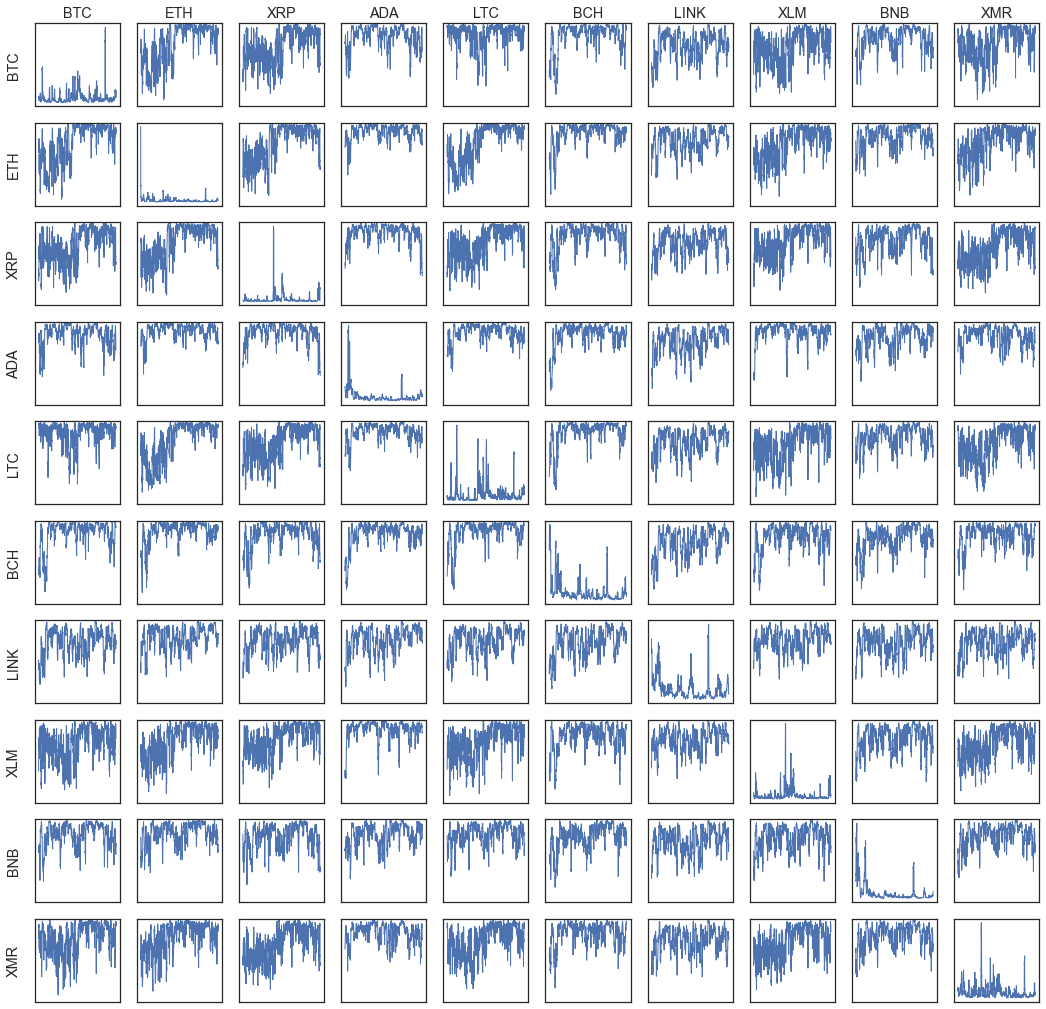

In [11]:
fig, axs = plt.subplots(10, 10, figsize=(18,18))
for i, c1 in enumerate(tqdm(coins)):
    for j, c2 in enumerate(coins):
        if c1==c2:
            axs[i][j].plot(df[c1].rolling(14).cov(), linewidth=1)
            axs[i][j].set_xticklabels([])
            axs[i][j].set_yticklabels([])
        else:
            axs[i][j].plot(df[c1].rolling(14).corr(df[c2]), linewidth=1)
            axs[i][j].set_ylim((-1,1))
            axs[i][j].set_xticklabels([])
            axs[i][j].set_yticklabels([])
for ax, col in zip(axs[0], coins):
    ax.set_title(col, size='large')
for ax, row in zip(axs[:,0], coins):
    ax.set_ylabel(row, size='large')
plt.savefig('plots/coin_corr.pdf')
plt.show()

In [12]:
# plot the evolution of condition number
stds = []
for w in range(1,30):
    kappas = []
    for i in range(0,len(universe)-w+1, w):
        train = universe.loc[i:i+w-1].drop('Date', axis=1).to_numpy()
        cov = EmpiricalCovariance().fit(train).covariance_
        kappas.append(np.linalg.cond(cov))
    stds.append(np.std(kappas))

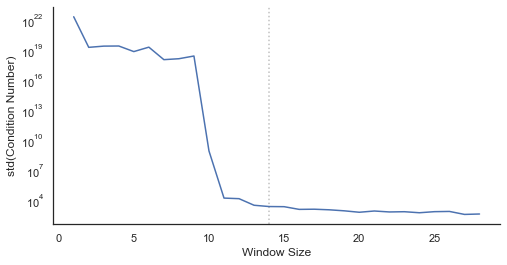

In [13]:
plt.plot(stds)
plt.gca().set(yscale="log")
plt.gca().axvline(14,ls=':', color='grey', zorder=-1, alpha=0.5)
sns.despine()
plt.ylabel('std(Condition Number)')
plt.xlabel('Window Size')
plt.savefig('plots/kappa_std.pdf')